# My proposed TDI Capstone project
I plan to use accelerometer data to build and train a model that is capable of automatically predicting what activity a person is engaged in. 

The motivation for building out a pipeline that detects motion-based activities from accelerometers data in wearable sensors is to apply it to health-related data. I'm interested in working with health-related data from wearables and I would use the model to detect freezing gait in Parkinson's patients.

I first use a dataset that allows me to demonstrate an intial deep-learning framework to classify time-series data into activity types. The dataset comes from https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer. 

The initial testing dataset collects data from a wearable accelerometer mounted on the chest. Uncalibrated Accelerometer Data are collected from 15 participants performing 7 activities.

For each participant, I split each of the x, y, z accelerometer time series into 1 second windows. Each window forms and observation and each window has an associated activity class label. I show that there is a class imbalance and deal with that. I build a 1D Convolutional neural network to classify 1 s windows into one of seven differnt activity types.

To evaluate my model, i collect several classification metrics and also show the confusion matrix to see how the model performed on a held out test set.

I propose an extension to this framework to improve on the performance.

My plan is to use this framework to detect freezing gaits in Parkinsons patients using this dataset https://archive.ics.uci.edu/ml/datasets/Daphnet+Freezing+of+Gait.


# Below is a description of the data used in the following demo

### Relevant Information:
<ul>
<li>The dataset collects data from a wearable accelerometer mounted on the chest</li>
<li>Sampling frequency of the accelerometer: 52 Hz</li>
<li>Accelerometer Data are Uncalibrated</li>
<li>Number of Participants: 15</li>
<li>Number of Activities: 7</li>
<li>Data Format: CSV</li>
</ul>


### Dataset Information

- Data are separated by participant
- Each file contains the following information: 
    - sequential number
    - x acceleration
    - y acceleration
    - z acceleration
    - label
- Labels are codified by numbers    
    - Working at Computer
    - Standing Up, Walking and Going up\down stairs
    - Standing
    - Walking
    - Going Up\Down Stairs
    - Walking and Talking with Someone
    - Talking while Standing
      

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split

In [2]:
participant_file_names = []
participants = []
for i in range(1,16):
    participant_file_names.append(np.genfromtxt('%i.csv'%(i), delimiter=','))
    participants.append(np.genfromtxt('%i.csv'%(i), delimiter=','))


In [3]:
participants_train = participants[:15]

In [4]:
import pandas as pd
from scipy.stats import mode
p = 50
TIME_PERIODS = p
num_sensors = 3
Y = []
X = []
 
for j in range(1, num_sensors+1):
    x = []
    
    for k in range(len(participants_train)):
        x_participant = pd.DataFrame(participants_train[k][:,j])
        x_participant = pd.concat([x_participant.shift(i) for i in range(p)], axis=1).dropna()
        x.append(x_participant)
        
    
    x = np.vstack(x)
    x = np.expand_dims(x,2)
    
    X.append(x.T)

    
y = [] 
for k in range(len(participants_train)): 
    y_participant = pd.DataFrame(participants_train[k][:,4])
    y_participant = y_participant[p-1:]
    y.append(y_participant)
    
y = np.vstack(y)
y = y.flatten()

In [5]:
X = np.array(X).squeeze()


In [6]:
y.shape

(1926161,)

In [7]:
X = X.T

# Look at data imbalances and biases

In [8]:
import pandas as pd
df = pd.DataFrame(y).reset_index()
df.columns = ['index', 'target']

Proportion: 0.3156
Proportion: 0.3082
Proportion: 0.1854
Proportion: 0.1125
Proportion: 0.0267
Proportion: 0.0249
Proportion: 0.0248
Proportion: 0.0019


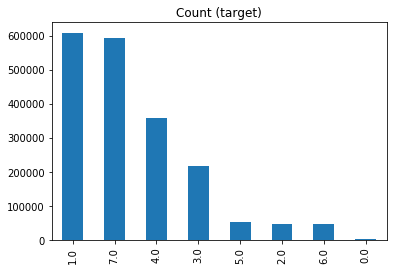

In [9]:
target_count = df.target.value_counts()
for index, row in target_count.items():
    print('Proportion:', round(row / np.sum(target_count), 4))

target_count.plot(kind='bar', title='Count (target)');

# Split into train and test and stratify on y so the same proportion of classes are in train and test

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Undersample the majority class using imblearn for training the network

In [41]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)   # Always use a fixed random seed to guarantee that when you run the code 
                                            # twice you will get the same outcome. 
                                            # This removes a factor of variation and will help keep you sane.
X_rus, y_rus = rus.fit_resample(X_train[:, :, 0], y_train)


In [42]:
X_ = X_train[rus.sample_indices_, :, :]
y_ = y_rus
len(y_)


23800

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_)


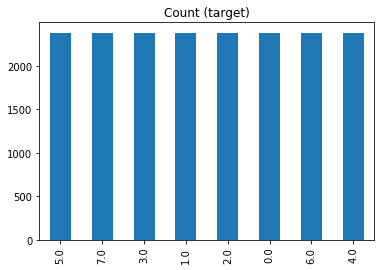

In [75]:
df = pd.DataFrame(y_train).reset_index()
df.columns = ['index', 'target']
target_count = df.target.value_counts()
target_count
target_count.plot(kind='bar', title='Count (target)');

# Model Input

As you can see we have a 3 dimensional vector of (samples, timesteps, features):

    -- 271 Different windows of data (each with a class label in the y array)
    -- The timesteps in that window (512 being the length of the window)
    -- accelerometer axis (x, y, z)

Lets just have a look at each of the axes in one of the windows as an example.

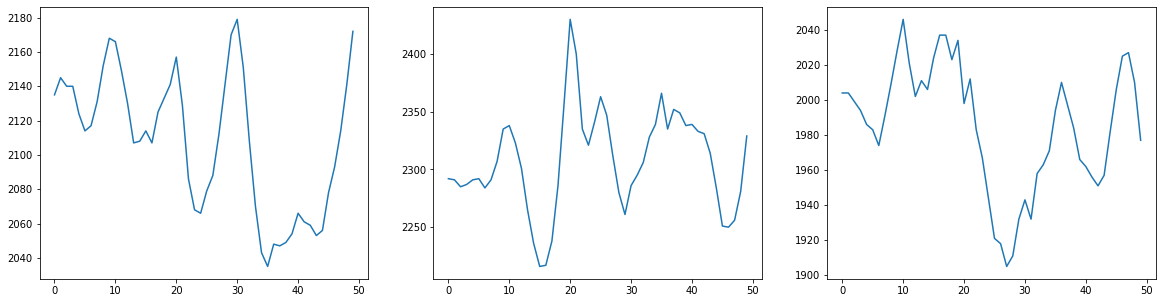

In [58]:
fig, ax = plt.subplots(1, num_sensors, figsize=[20, 5])
for i in range(len(ax)):
    ax[i].plot(X_train[1400, :, i])

We have 2168 such windows and a corresponding class label for each. There are 271 observations for each of the 8 classes (7*271 = 2168)

In [59]:
X_.shape
y_.shape

(23800,)

# Define a 1D CNN model to find the function mapping each set of x, y, z accelerometer windows into an associated class label

define CNN model parameters

In [60]:
n_filters = 16
filter_size = 3
pool_size = 2

In [61]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
print(tf.__version__)
from keras.layers import BatchNormalization
y_binary_train = to_categorical(y_train)
y_binary_val = to_categorical(y_val)

2.4.1


In [62]:
tf.keras.backend.clear_session()

## define the CNN model

In [63]:
tf.random.set_seed(1)

model = tf.keras.models.Sequential([
    #tf.keras.Input(input_shape=(TIME_PERIODS,num_sensors)),
    tf.keras.layers.Reshape((TIME_PERIODS, num_sensors), input_shape=(TIME_PERIODS,num_sensors)),
    BatchNormalization(),
    tf.keras.layers.Conv1D(n_filters, filter_size, activation='relu', 
                           padding='same',input_shape=(TIME_PERIODS, num_sensors),
                          name='conv1'),
    tf.keras.layers.Conv1D(n_filters, filter_size, padding='same', 
                           activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling1D(pool_size, name='maxpool'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(y_binary_train.shape[1], activation='softmax')
])
 
    
#model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', 'AUC', 'Recall', 'Precision'])


print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 50, 3)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 3)             12        
_________________________________________________________________
conv1 (Conv1D)               (None, 50, 16)            160       
_________________________________________________________________
conv2 (Conv1D)               (None, 50, 16)            784       
_________________________________________________________________
maxpool (MaxPooling1D)       (None, 25, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               4

## fit the model to the training data

In [64]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # early stopping. Stop training based 
                                                                            # on your measured validation loss to 
                                                                            # catch your model just as it’s about 
                                                                            # to overfit.
history = model.fit(X_train, y_binary_train, validation_data=(X_val, y_binary_val),
                    epochs=100, batch_size=100, 
                    callbacks=[callback], verbose=1)


Epoch 1/100
191/191 [==============================] - 3s 12ms/step - loss: 1.8227 - accuracy: 0.3274 - auc: 0.7208 - recall: 0.0624 - precision: 0.5785 - val_loss: 7.4715 - val_accuracy: 0.1252 - val_auc: 0.5298 - val_recall: 0.1250 - val_precision: 0.1255
Epoch 2/100
191/191 [==============================] - 2s 8ms/step - loss: 1.4925 - accuracy: 0.4575 - auc: 0.8376 - recall: 0.1901 - precision: 0.6429 - val_loss: 1.6821 - val_accuracy: 0.3613 - val_auc: 0.7885 - val_recall: 0.1821 - val_precision: 0.5460
Epoch 3/100
191/191 [==============================] - 2s 8ms/step - loss: 1.3656 - accuracy: 0.4974 - auc: 0.8654 - recall: 0.2518 - precision: 0.6804 - val_loss: 1.3004 - val_accuracy: 0.5218 - val_auc: 0.8773 - val_recall: 0.2775 - val_precision: 0.6834
Epoch 4/100
191/191 [==============================] - 2s 8ms/step - loss: 1.2753 - accuracy: 0.5282 - auc: 0.8826 - recall: 0.3045 - precision: 0.6942 - val_loss: 1.2452 - val_accuracy: 0.5389 - val_auc: 0.8891 - val_recall: 0.

## It seems our model performs equally well on the train and validation.
The fitting is stopped when the validation loss no longer decreases

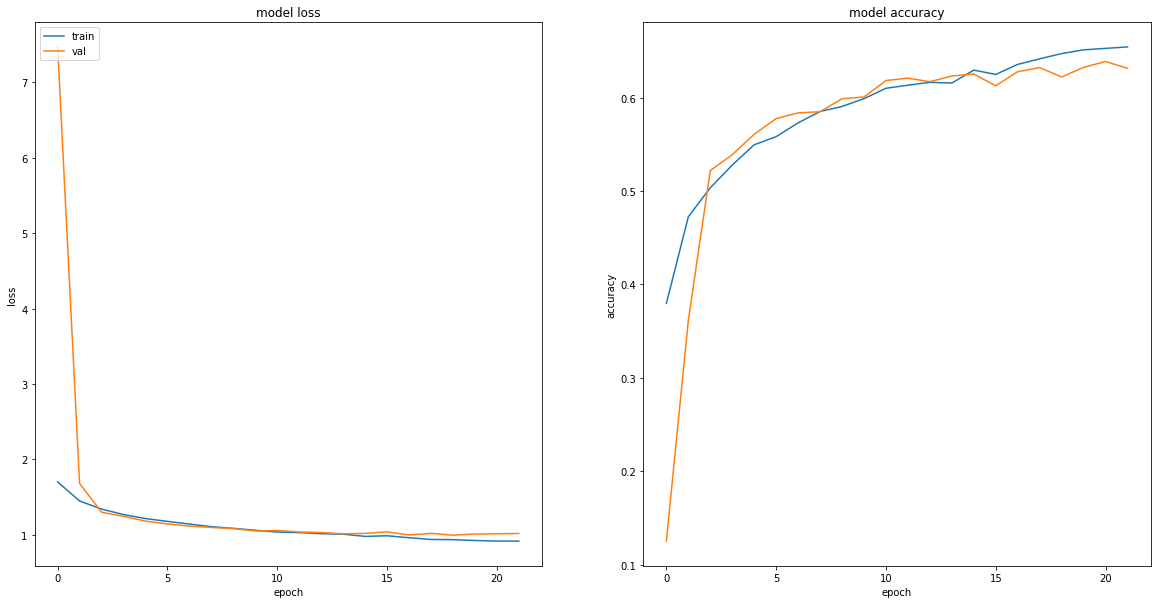

In [65]:
# summarize history for loss and accuracy
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
plt.show()

## Now test on the held out test set and evaluate our test predictions using a confusion matrix

In [66]:
from sklearn.metrics import confusion_matrix

In [67]:
ynew = model.predict(X_test)
predictions = (-ynew).argsort()[:, 0]

In [69]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', np.round(conf_mat/np.sum(conf_mat, axis=0), 2))

Confusion matrix:
 [[0.03 0.   0.   0.   0.   0.   0.   0.  ]
 [0.58 0.94 0.54 0.07 0.   0.05 0.03 0.06]
 [0.01 0.02 0.13 0.01 0.   0.01 0.01 0.01]
 [0.09 0.01 0.11 0.42 0.06 0.27 0.1  0.05]
 [0.07 0.   0.05 0.18 0.9  0.18 0.26 0.01]
 [0.01 0.   0.01 0.02 0.01 0.2  0.02 0.01]
 [0.02 0.   0.01 0.01 0.01 0.06 0.21 0.01]
 [0.2  0.03 0.16 0.29 0.01 0.23 0.37 0.86]]


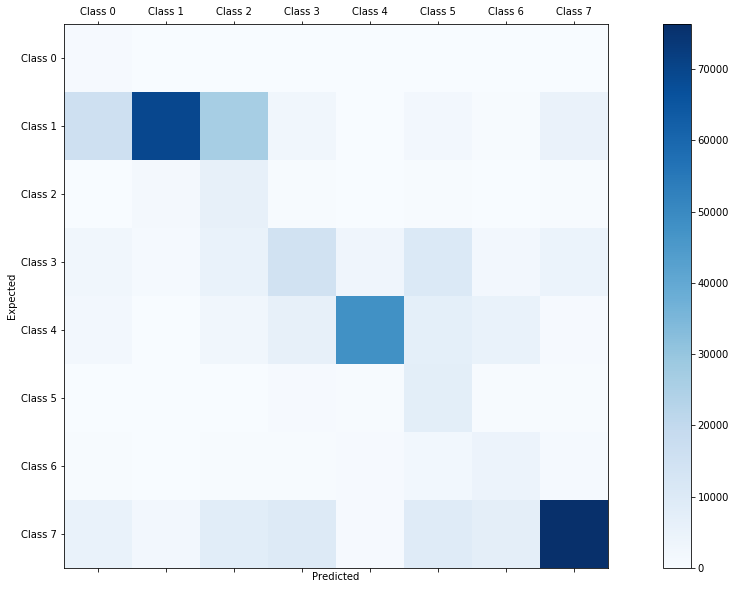

In [70]:
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7',]
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [71]:
# evaluate model on test
y_test_binary = to_categorical(y_test)
results = model.evaluate(X_test, y_test_binary, batch_size=64, verbose=0)

In [72]:
print("Test loss = {}\nTest acc = {}\nTest AUC = {}\nTestRecall = {}\nTest Precision = {}".format(results[0], results[1],
                                                                                        results[2], results[3],
                                                                                        results[4]))


Test loss = 1.1755802631378174
Test acc = 0.588905930519104
Test AUC = 0.9048755764961243
TestRecall = 0.4281175434589386
Test Precision = 0.6624664664268494


# Conclusions
I got 96% correct for class 0
The rest are between 60 and 70% except for classes 3 and 6. Maybe we should look into these classes. Possibly we should change the window size for breaking up the time series. Maybe it's hard to classify on the raw time series and we should do some time series processing first.

# Where to from here?
One idea would be to do the DWT transform on each time series and then predict the classes from DWT coefficients. In this approach, we would perform 2D convolution across the DWT coefficients over time (y-axis = value for each DWT coefficient and x-axis = time)